# Transformer Model
## - German to English Translation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy 
import numpy as np

import random
import math
import time

## Preprocessing

In [2]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

SRC = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
                                                   fields = (SRC, TRG))

In [3]:
print(f'Number of training examples: {len(train_data.examples)}')
print(f'Number of validation examples: {len(valid_data.examples)}')
print(f'Number of test examples: {len(test_data.examples)}')
print()
print(vars(train_data.examples[0]))

Number of training examples: 29000
Number of validation examples: 1014
Number of test examples: 1000

{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


In [4]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

print(f"Unique tokens in source (de) vocab: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocab: {len(TRG.vocab)}")

Unique tokens in source (de) vocab: 7854
Unique tokens in target (en) vocab: 5893


In [6]:
device = ('cpu')
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
                                                    (train_data, valid_data, test_data),
                                                    batch_size = BATCH_SIZE,
                                                    device = device)



## Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout,
                device, max_length = 100):
        #pf_dim = dimension of the feedfoward network (default is 2048).
        
        #max_length defines the max number of indices the Positional Encoder can provide to 
        #the numericalized tokens (or sentences).
        #E.g. "Sun is shining." - <sos>. 0, "Sun", 1.. (keep in mind the words are numericalized
        #so you won't see the actual word).
        super(Encoder, self).__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        #This embedding is done in the Positional Encoder before input is fed into Encoder.
        #Since Transformer does not take one input at a time (all input at once - parellization),
        #the Encoder will not know the order of the sentence, which can lead to construed meanings.
        #E.g. "dog ate cat" can be read as "ate dog cat" or "cat ate dog".
        #The Position Encoder will add the order of the input numericalized tokens.
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim,
                                                 dropout, device)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropoout(dropout)
        
        #The tok_embedding is multiplied by the square root of hid_dim as this has emprically 
        #shown to reduce variances in embeddings and makes the model easier to train.
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos = [batch size, src len]
        
        #The tok_embedding is first multiplied by the scale and summed w/ pos_embedding
        #before being passed into into the Encoder.
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src = [batch size, src len, hid dim]
        
        return src

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super(EncoderLayer, self).__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwrardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
        def forward(self, src, src_mask):
            #src = [batch size, src len, hid dim]
            #src_mask = [batch size, src len]
            
            #Self Attention Layer
            _src, _ = self.self_attention(src, src, src, src_mask)
            
            #Dropout, Residual Connection and Normalization Layer
            src = self.self_attn_layer_norm(src + self.dropout(_src))
            
            #src = [batch size, src len, hid dim]
            
            #Positionwise feedforward
            _src = self.positionwise_feedforward(src)
            
            #Dropout, Residual Layer and Normalization Layer (of Feedforward Layer)
            src = self.ff_layer_norm(src + self.dropout(src))
            
            #src = [batch_size, src len, hid dim]
            
            return src

A new concept used by the Transformer is the Multi-Head Attention Layer (MHAL).

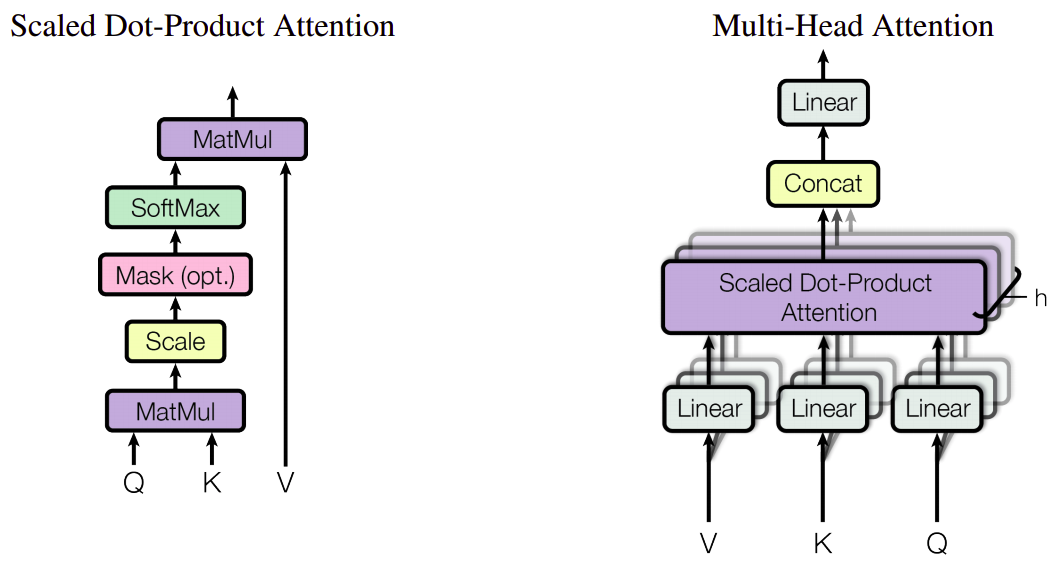

Keep in mind that all the words are fed in parellally to every layer in the Transformer. However, to understand the MHAL better, we will describing what happens when EACH word is passed into it.

E.g. "A cat climbed the tree."
First the Embedding matrix of "A" will be passed in.
Let's say X = Embedding vector of "A".

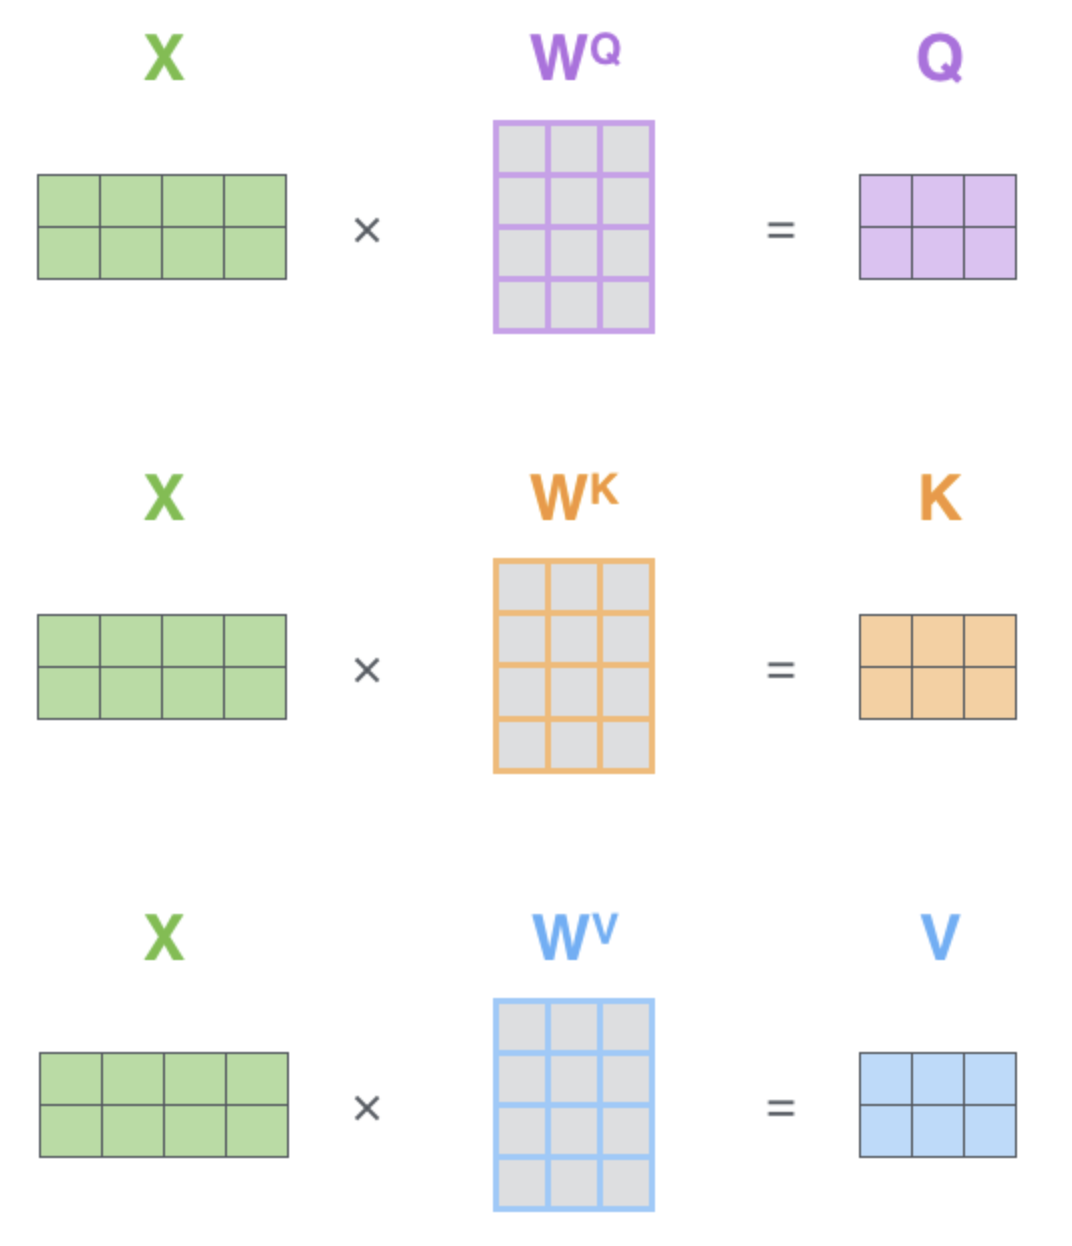


Initially, vectors V(value), K(key) and Q(Query) will be produced by splitting the Embedding matrix into smaller componants (doesn't necessarily have to be smaller).
They will then be passed through a Linear layer which will add weight to each vector.
This is repeated a total of 8 times in the Transformer paper.
---> [Wv0, Wk0, WQ0] then [Wv1, Wk1, WQ1] ..

The vectors are then passed through a Scaled Dot-Product Attention Layer where:
Query and Key are multiplied --> total is divided by the square root of the *number of head dimensions --> Softmax function is applied to this total and multiplied by the Value vector.
*Number of head dimensions = Hidden layer dimension (Embedding matrix) / number of heads
The Q, K and V vectors are split into 

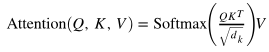

This is done 8 times according to the Transformer paper. Therefore each Head can be given as:
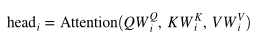

The heads are created because it makes the weights added to X to create the V, K and Q vectors more flexible. 
These vectors are randomly initialized at the start and after training it will be modified to minimize the loss.

To help better visualize what happens in the Scaled Dot-Product Attention:

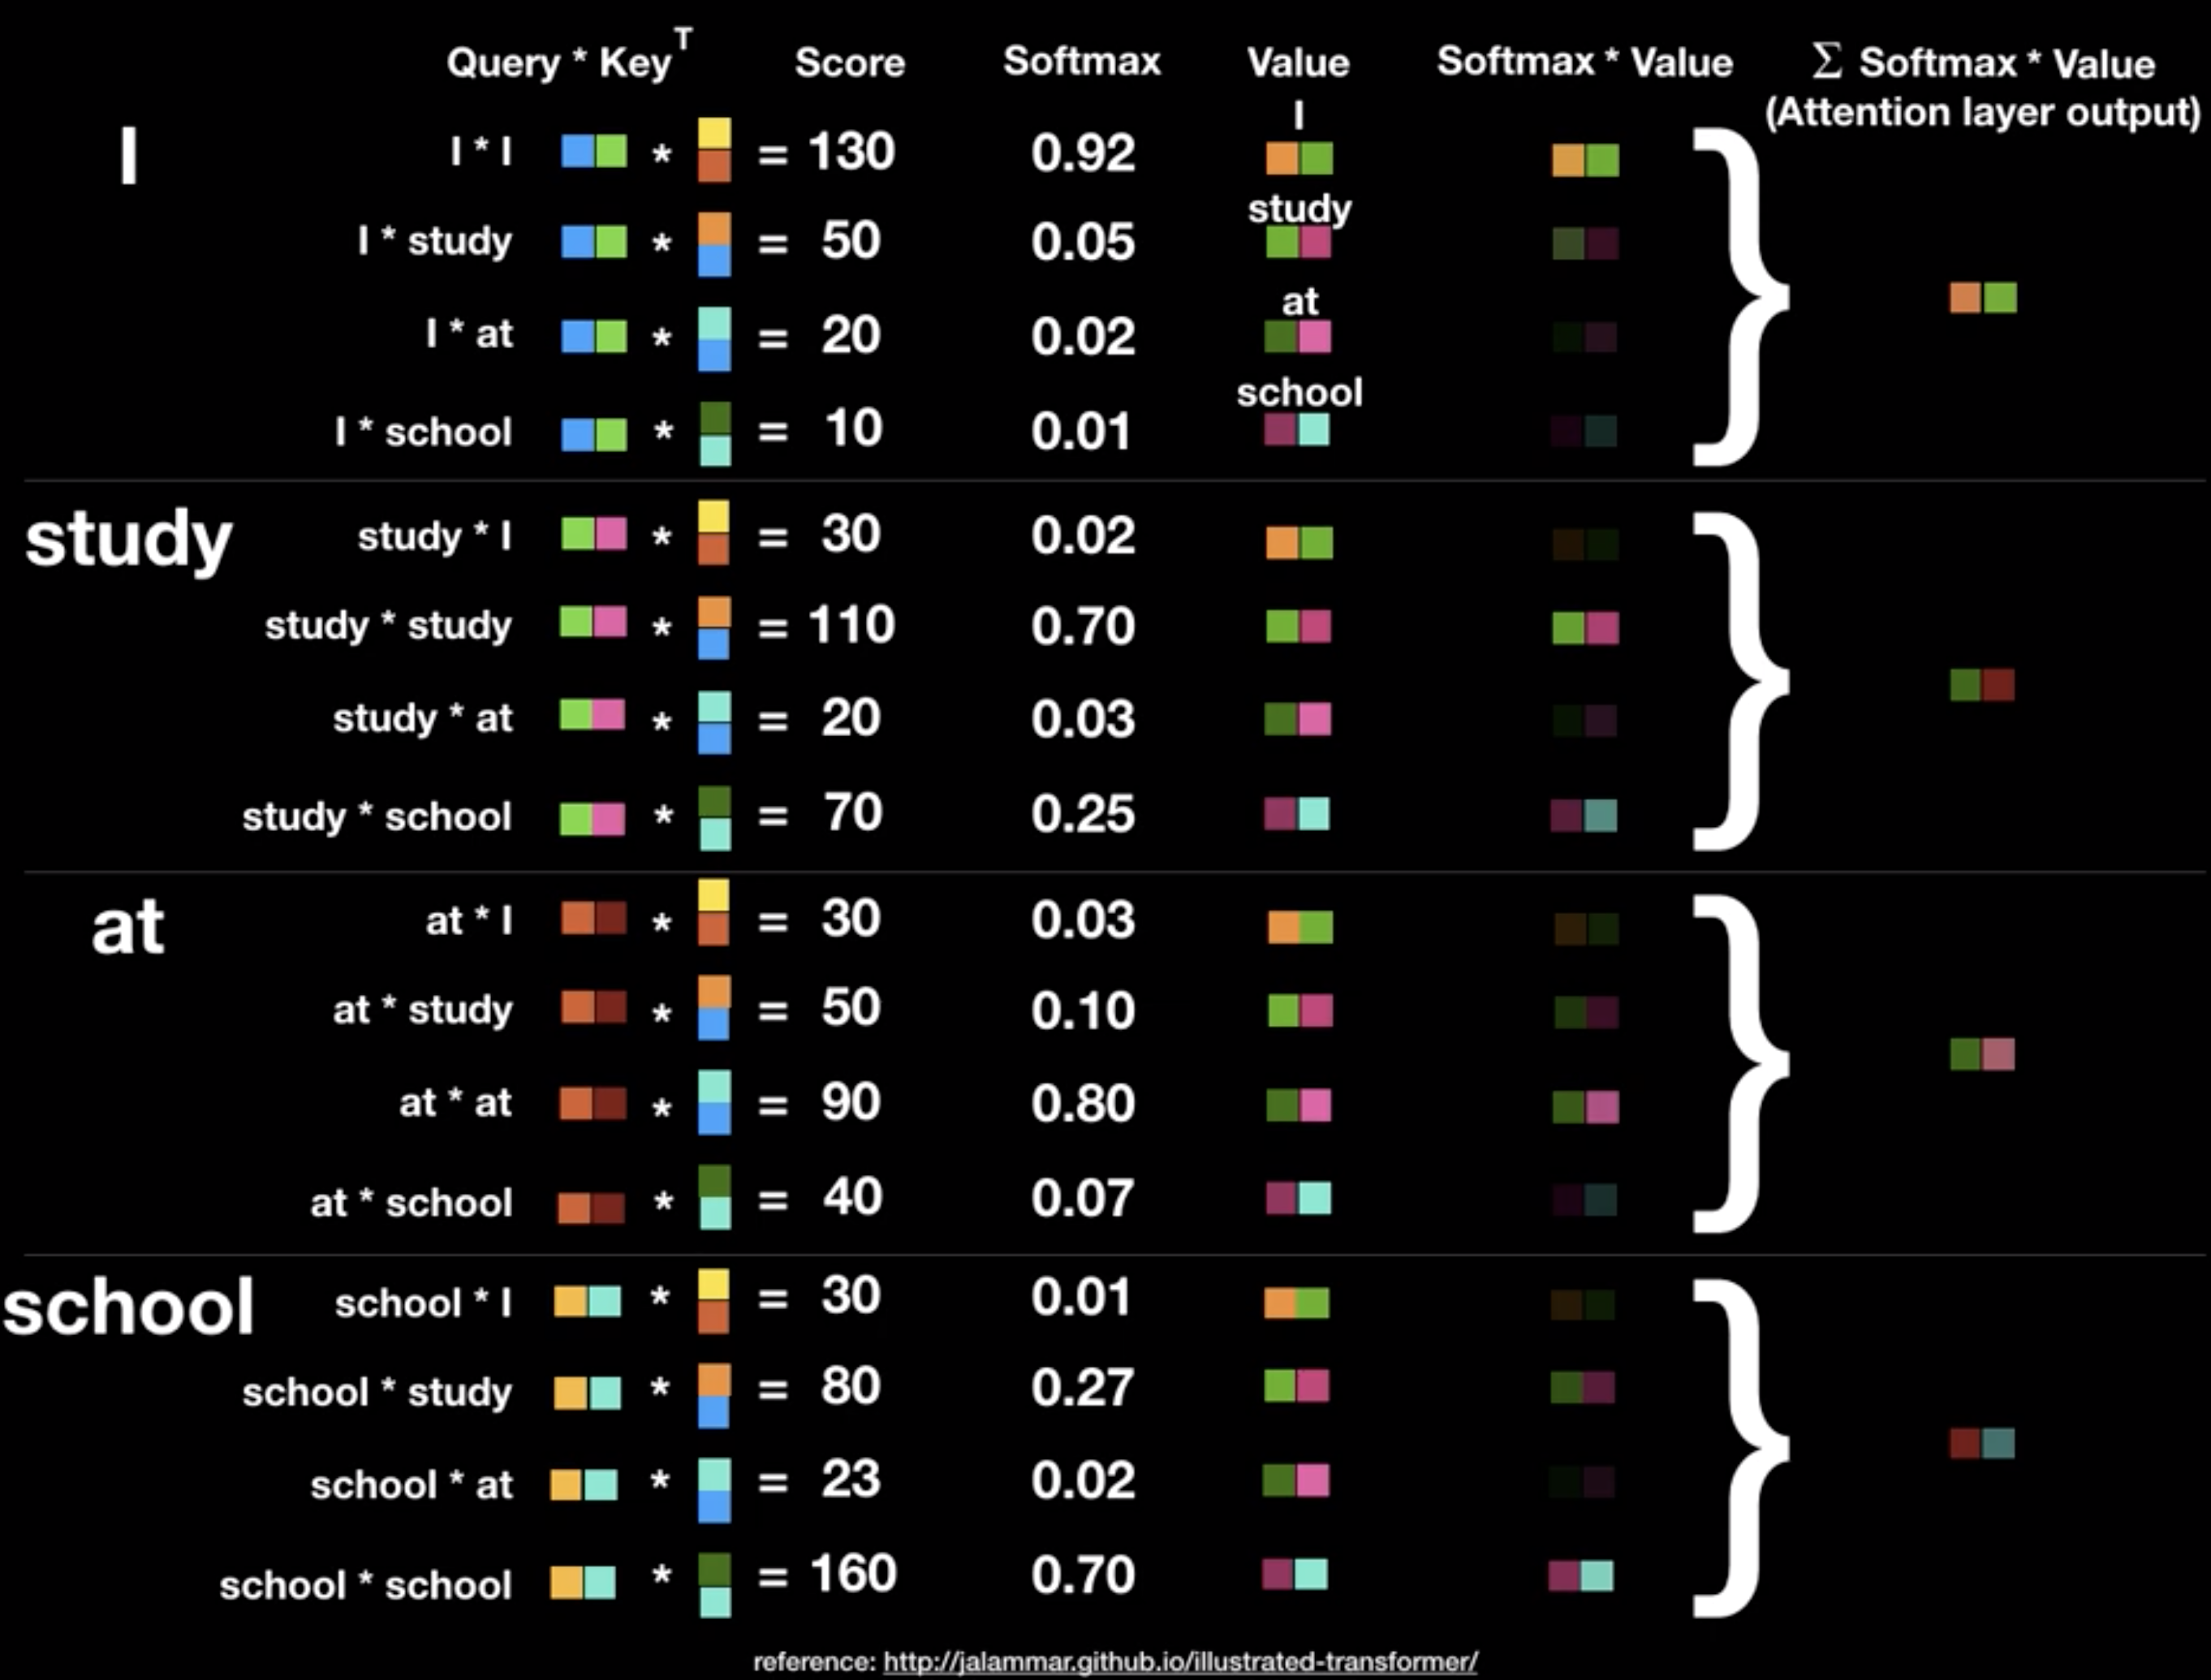

Keep in mind that the Q, K and V vectors have the same length making it easy to multiply them.
After the 8 Attention Vectors for each word are created, they are concatanated and multiplied with a weight (Wo) as only one Attention vector per word is passed to Feed Forward layer.

The Attention vector is passed through a Dropout layer, however the explanation for it is not given in the paper.




In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super(MultiHeadAttentionLayer, self).__init()
        
        #The hidden layer is split and therefore, can only contain whole numbers.
        #If the remainder is not 0, then Exception is called.
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        # Q - Query, K - Key, V - Value
        #Think of Query as in the current word that is being passed into the Decoder for translation.
        #In the given database, the model tries to find a matching Key.
        #The model returns a Value after it finds the matching Key. 
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc.v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
    
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        Q = self.fc_q(self)
        K = self.fc_k(self)
        V = self.fc_v(self)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
        
        #.view() reshapes the Tensor.
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch size, n heads, query len, key len]
        
        #Note that attention is passed through dropout layer before being multiplied with V.
        x = torch.matmul(self.dropout(attention), V)
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super(PositionwiseFeedforwardLayer, self).__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, seq len, hid dim]
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x
    

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device,
                max_length = 100):
        super(Decoder, self).__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device) 
                                    for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mark, src_mask):
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
        
        return output, attention

In [1]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super(DecoderLayer, self).__.init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention 
        _trg, _ = self.self.attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        
        #encoder attention 
        _trg, attention = self.encoder_attnetion(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

NameError: name 'nn' is not defined

In [ ]:
Questions:
    1) What is the definition of dimensions in a feed forward network (parameter pf_dim).
    2) Not sure what nn.ModuleList is for.
    

In [ ]:
http://jalammar.github.io/illustrated-transformer/
https://www.youtube.com/watch?v=TQQlZhbC5ps&t=67s
https://www.youtube.com/watch?v=z1xs9jdZnuY
    
        